In [6]:
import pandas as pd
import numpy as np
import datetime
from sklearn.pipeline import Pipeline
from dateutil.relativedelta import relativedelta
import warnings
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import xgboost as xgb

from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

In [7]:
# Suppress the SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)
pd.set_option('future.no_silent_downcasting', True)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
#Load the data from the csv file
df = pd.read_csv('d:/code/data/data.csv', encoding='ISO-8859-1')
df_snapshot = pd.read_csv('d:/code/data/customer_behavior_ecom_snapshot_FRM.csv')

In [9]:
#Convert the date columns to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
df_snapshot

,customer_id,total_successful_amount_past_5_month,num_successful_orders_past_5_month,total_successful_amount_past_4_month,num_successful_orders_past_4_month,total_successful_amount_past_3_month,num_successful_orders_past_3_month,total_successful_amount_past_2_month,num_successful_orders_past_2_month,total_successful_amount_past_1_month,...,num_successful_orders_future_1_month,total_successful_amount_future_2_month,num_successful_orders_future_2_month,time_snapshot,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore
0,12347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,711.79,...,29.0,0.0,0.0,2011-01-01,24,31,711.79,2,4,5
1,12348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,892.80,...,6.0,0.0,0.0,2011-01-01,15,17,892.80,5,3,5
2,12370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1868.02,...,0.0,0.0,0.0,2011-01-01,14,91,1868.02,5,5,5
3,12377.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1001.52,...,34.0,0.0,0.0,2011-01-01,11,43,1001.52,5,4,5
4,12383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.72,...,32.0,0.0,0.0,2011-01-01,9,37,600.72,5,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37431,14349.0,NaN,NaN,NaN,NaN,NaN,NaN,133.50,31.0,0.00,...,NaN,NaN,NaN,2012-01-01,32,31,133.50,5,3,1
37432,18058.0,NaN,NaN,NaN,NaN,NaN,NaN,170.16,3.0,0.00,...,NaN,NaN,NaN,2012-01-01,31,3,170.16,5,1,1
37433,12953.0,NaN,NaN,NaN,NaN,NaN,NaN,329.85,17.0,0.00,...,NaN,NaN,NaN,2012-01-01,31,17,329.85,5,2,2
37434,12966.0,NaN,NaN,NaN,NaN,NaN,NaN,160.18,10.0,0.00,...,NaN,NaN,NaN,2012-01-01,31,10,160.18,5,1,1


In [11]:
df_snapshot_truncate = df_snapshot[(df_snapshot.time_snapshot<='2011-12-1')]

In [12]:
df_snapshot_truncate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33064 entries, 0 to 33063
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   customer_id                             33064 non-null  float64
 1   total_successful_amount_past_5_month    17705 non-null  float64
 2   num_successful_orders_past_5_month      17705 non-null  float64
 3   total_successful_amount_past_4_month    21065 non-null  float64
 4   num_successful_orders_past_4_month      21065 non-null  float64
 5   total_successful_amount_past_3_month    24723 non-null  float64
 6   num_successful_orders_past_3_month      24723 non-null  float64
 7   total_successful_amount_past_2_month    28733 non-null  float64
 8   num_successful_orders_past_2_month      28733 non-null  float64
 9   total_successful_amount_past_1_month    33064 non-null  float64
 10  num_successful_orders_past_1_month      33064 non-null  int64  

In [13]:
df_snapshot_truncate['is_churn_future_1_month'] = df_snapshot_truncate.num_successful_orders_future_1_month==0

In [14]:
df_snapshot_truncate.is_churn_future_1_month.value_counts(normalize=True)

is_churn_future_1_month
True     0.718637
False    0.281363
Name: proportion, dtype: float64

In [15]:
numeric_df = df_snapshot_truncate.select_dtypes(include=['number', 'bool'])
# Choose a target column for correlation
target_column = 'is_churn_future_1_month'

# Compute correlation with other numeric columns
correlations = numeric_df.corr()[target_column].drop(target_column)

# Print result
print(correlations)

customer_id                               0.019137
total_successful_amount_past_5_month     -0.161218
num_successful_orders_past_5_month       -0.198524
total_successful_amount_past_4_month     -0.157037
num_successful_orders_past_4_month       -0.197525
total_successful_amount_past_3_month     -0.147537
num_successful_orders_past_3_month       -0.195385
total_successful_amount_past_2_month     -0.148248
num_successful_orders_past_2_month       -0.185675
total_successful_amount_past_1_month     -0.146039
num_successful_orders_past_1_month       -0.157240
total_successful_amount_future_1_month   -0.278118
num_successful_orders_future_1_month     -0.418817
total_successful_amount_future_2_month   -0.136486
num_successful_orders_future_2_month     -0.146867
recency                                   0.231808
frequency                                -0.210438
monetary                                 -0.166218
RecencyScore                             -0.253279
FrequencyScore                 

In [16]:
time_split = '2011-11-01'
df_train = df_snapshot_truncate[df_snapshot_truncate.time_snapshot<time_split]
df_test = df_snapshot_truncate[df_snapshot_truncate.time_snapshot>=time_split]

In [17]:
df_train.shape, df_test.shape

((24723, 23), (8341, 23))

In [18]:
df_train.is_churn_future_1_month.value_counts(normalize=True), df_test.is_churn_future_1_month.value_counts(normalize=True)

(is_churn_future_1_month
 True     0.706023
 False    0.293977
 Name: proportion, dtype: float64,
 is_churn_future_1_month
 True     0.756024
 False    0.243976
 Name: proportion, dtype: float64)

In [19]:
features = ['customer_id', 
            #'total_successful_amount_past_5_month', 'num_successful_orders_past_5_month',
            #'total_successful_amount_past_4_month', 'num_successful_orders_past_4_month',
            'total_successful_amount_past_3_month', 'num_successful_orders_past_3_month', 
            'total_successful_amount_past_2_month', 'num_successful_orders_past_2_month',
            'total_successful_amount_past_1_month', 'num_successful_orders_past_1_month',
            'recency', 'frequency', 'monetary', 'FrequencyScore', 'MonetaryScore', 'RecencyScore']
target = 'is_churn_future_1_month'
X_train = df_train[features].fillna(0)
y_train = df_train[target]
X_test = df_test[features].fillna(0)
y_test = df_test[target]

In [20]:
# Standardize the features (important for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train Logistic Regression model
model = model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.3f}")

f1_score_value = f1_score(y_test, y_pred)
print(f"Model F1 Score: {f1_score_value:.3f}")


Model Accuracy: 0.760
Model F1 Score: 0.847


In [21]:
# Standardize the features (important for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train Logistic Regression model
model = LogisticRegression()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")

# Make predictions
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.3f}")

f1_score_value = f1_score(y_test, y_pred)
print(f"Model F1 Score: {f1_score_value:.3f}")


Train Accuracy: 0.746
Model Accuracy: 0.767
Model F1 Score: 0.853


In [22]:
# Standardize the features (important for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train Logistic Regression model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.3f}")

f1_score_value = f1_score(y_test, y_pred)
print(f"Model F1 Score: {f1_score_value:.3f}")

Model Accuracy: 0.754
Model F1 Score: 0.842


In [23]:
# Standardize the features (important for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train Logistic Regression model
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.3f}")

f1_score_value = f1_score(y_test, y_pred)
print(f"Model F1 Score: {f1_score_value:.3f}")

Model Accuracy: 0.769
Model F1 Score: 0.854


In [24]:
# Standardize the features (important for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train Logistic Regression model
model = CatBoostClassifier(iterations=1000, 
                                    learning_rate=0.001, 
                                    depth=4, 
                                    loss_function='Logloss', 
                                    verbose=100)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict_proba(X_test)[:,1]
y_pred = y_pred>=0.5
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.3f}")

f1_score_value = f1_score(y_test, y_pred)
print(f"Model F1 Score: {f1_score_value:.3f}")

0:	learn: 0.6928084	total: 179ms	remaining: 2m 59s
100:	learn: 0.6620626	total: 736ms	remaining: 6.55s
200:	learn: 0.6371720	total: 1.23s	remaining: 4.9s
300:	learn: 0.6169930	total: 1.74s	remaining: 4.04s
400:	learn: 0.6005616	total: 2.23s	remaining: 3.33s
500:	learn: 0.5871549	total: 2.73s	remaining: 2.72s
600:	learn: 0.5761767	total: 3.22s	remaining: 2.14s
700:	learn: 0.5672123	total: 3.71s	remaining: 1.58s
800:	learn: 0.5598644	total: 4.18s	remaining: 1.04s
900:	learn: 0.5538384	total: 4.68s	remaining: 515ms
999:	learn: 0.5488549	total: 5.18s	remaining: 0us
Model Accuracy: 0.779
Model F1 Score: 0.863


In [25]:
y_pred

array([False,  True, False, ...,  True,  True,  True])

0:	learn: 0.6928084	total: 10.9ms	remaining: 5.46s
100:	learn: 0.6620626	total: 504ms	remaining: 1.99s
200:	learn: 0.6371720	total: 997ms	remaining: 1.48s
300:	learn: 0.6169930	total: 1.46s	remaining: 967ms
400:	learn: 0.6005616	total: 1.95s	remaining: 482ms
499:	learn: 0.5872712	total: 2.42s	remaining: 0us
Model train Accuracy: 0.779
Model F1 Score: 0.863


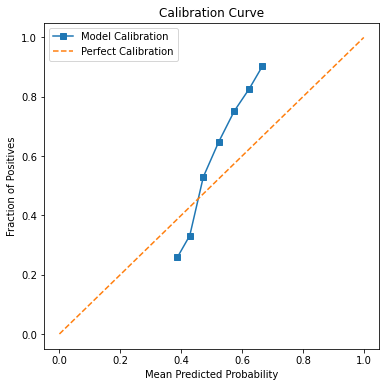

In [ ]:
# Initialize and train Logistic Regression model
# model = CatBoostClassifier(iterations=500, 
#                                     learning_rate=0.001, 
#                                     depth=4, 
#                                     loss_function='Logloss', 
                                    # verbose=100)
model = RandomForestClassifier(max_depth=6, n_estimators=300)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:,1]
y_pred = y_pred>=0.5
print(f"Model test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Model F1 Score: {f1_score(y_test, y_pred):.3f}")

# print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
# print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))
# Make predictions
y_pred = model.predict_proba(X_test)[:,1]

# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins=20)

# Plot calibration curve
plt.figure(figsize=(6, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model Calibration")
plt.plot([0, 1], [0, 1], "--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

(array([ 122.,  221.,  267.,  332.,  647., 1063., 1344., 1304., 1543.,
        1498.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

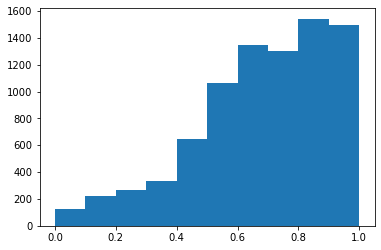

In [27]:
plt.hist(y_pred)

In [28]:
y_pred = model.predict_proba(X_test)
y_pred[:,1]

array([0.46, 0.48, 0.71, ..., 0.92, 0.66, 0.81])

In [29]:
import numpy as np
bins = np.linspace(0.0, 1.0, 2 + 1)
bins

array([0. , 0.5, 1. ])

In [30]:
import numpy as np
from sklearn.calibration import calibration_curve
y_true = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1])
y_pred = np.array([0.1, 0.2, 0.3, 0.4, 0.65, 0.7, 0.8, 0.9,  1.])
prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=6)
prob_true, prob_pred

(array([0. , 0. , 0. , 0. , 0.5, 1. ]),
 array([0.1 , 0.25, 0.4 , 0.65, 0.75, 0.95]))

In [31]:
bins = np.linspace(0.0, 1.0, 3 + 1)
binids = np.searchsorted(bins[1:-1], y_pred)
binids

array([0, 0, 0, 1, 1, 2, 2, 2, 2], dtype=int64)

In [32]:
bin_sums = np.bincount(binids, weights=y_pred, minlength=len(bins))
bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
bin_total = np.bincount(binids, minlength=len(bins))

nonzero = bin_total != 0
prob_true = bin_true[nonzero] / bin_total[nonzero]
prob_pred = bin_sums[nonzero] / bin_total[nonzero]
nonzero,bin_sums, bin_true, bin_total, prob_true, prob_pred

(array([ True,  True,  True, False]),
 array([0.6 , 1.05, 3.4 , 0.  ]),
 array([0., 0., 3., 0.]),
 array([3, 2, 4, 0], dtype=int64),
 array([0.  , 0.  , 0.75]),
 array([0.2  , 0.525, 0.85 ]))